In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Translation files

In [2]:
from fastai.text import *

French/English parallel texts from http://www.statmt.org/wmt15/translation-task.html .  It was created by Chris Callison-Burch, who crawled millions of web pages and then used *a set of simple heuristics to transform French URLs onto English URLs (i.e. replacing "fr" with "en" and about 40 other hand-written rules), and assume that these documents are translations of each other*.

In [3]:
PATH = Path('data/translate')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)
fname='giga-fren.release2.fixed'
en_fname = PATH/f'{fname}.en'
fr_fname = PATH/f'{fname}.fr'

In [ ]:
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')

lines = ((re_eq.search(eq), re_fq.search(fq)) 
         for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))

qs = [(e.group(), f.group()) for e,f in lines if e and f]

In [ ]:
pickle.dump(qs, (PATH/'fr-en-qs.pkl').open('wb'))

In [ ]:
qs = pickle.load((PATH/'fr-en-qs.pkl').open('rb'))

In [ ]:
qs[:5], len(qs)

In [ ]:
en_qs,fr_qs = zip(*qs)

In [ ]:
en_tok = Tokenizer.proc_all_mp(partition_by_cores(en_qs))

In [ ]:
fr_tok = Tokenizer.proc_all_mp(partition_by_cores(fr_qs), 'fr')

In [ ]:
en_tok[0], fr_tok[0]

In [ ]:
np.percentile([len(o) for o in en_tok], 90), np.percentile([len(o) for o in fr_tok], 90)

In [ ]:
keep = np.array([len(o)<30 for o in en_tok])

In [ ]:
en_tok = np.array(en_tok)[keep]
fr_tok = np.array(fr_tok)[keep]

In [ ]:
pickle.dump(en_tok, (PATH/'en_tok.pkl').open('wb'))
pickle.dump(fr_tok, (PATH/'fr_tok.pkl').open('wb'))

In [4]:
en_tok = pickle.load((PATH/'en_tok.pkl').open('rb'))
fr_tok = pickle.load((PATH/'fr_tok.pkl').open('rb'))

In [5]:
def toks2ids(tok,pre):
    freq = Counter(p for o in tok for p in o)
    itos = [o for o,c in freq.most_common(40000)]
    itos.insert(0, '_bos_')
    itos.insert(1, '_pad_')
    itos.insert(2, '_eos_')
    itos.insert(3, '_unk')
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    ids = np.array([([stoi[o] for o in p] + [2]) for p in tok])
    np.save(TMP_PATH/f'{pre}_ids.npy', ids)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos.pkl', 'wb'))
    return ids,itos,stoi

In [6]:
en_ids,en_itos,en_stoi = toks2ids(en_tok,'en')
fr_ids,fr_itos,fr_stoi = toks2ids(fr_tok,'fr')

In [7]:
def load_ids(pre):
    ids = np.load(TMP_PATH/f'{pre}_ids.npy')
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos.pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    return ids,itos,stoi

In [8]:
en_ids,en_itos,en_stoi = load_ids('en')
fr_ids,fr_itos,fr_stoi = load_ids('fr')

In [ ]:
[fr_itos[o] for o in fr_ids[0]], len(en_itos), len(fr_itos)

## Word vectors

fasttext word vectors available from https://fasttext.cc/docs/en/english-vectors.html

In [ ]:
# ! pip install git+https://github.com/facebookresearch/fastText.git

In [9]:
import fastText as ft

To use the fastText library, you'll need to download [fasttext word vectors](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) for your language (download the 'bin plus text' ones).

In [ ]:
def get_vecs(lang, ft_vecs):
    vecd = {w:ft_vecs.get_word_vector(w) for w in ft_vecs.get_words()}
    pickle.dump(vecd, open(PATH/f'wiki.{lang}.pkl','wb'))
    return vecd

In [ ]:
en_vecs = ft.load_model(str((PATH/'wiki.en.bin')))

In [ ]:
en_vecd = get_vecs('en', en_vecs)

In [ ]:
fr_vecs = ft.load_model(str((PATH/'wiki.fr.bin')))

In [ ]:
fr_vecd = get_vecs('fr', fr_vecs)

In [10]:
en_vecd = pickle.load(open(PATH/'wiki.en.pkl','rb'))
fr_vecd = pickle.load(open(PATH/'wiki.fr.pkl','rb'))

In [ ]:
# ft_words = ft_vecs.get_words(include_freq=True)
# ft_word_dict = {k:v for k,v in zip(*ft_words)}
# ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])

# len(ft_words)

In [26]:
dim_en_vec = len(en_vecd[','])
dim_fr_vec = len(fr_vecd[','])
dim_en_vec,dim_fr_vec

(300, 300)

In [27]:
en_vecs = np.stack(list(en_vecd.values()))
en_vecs.mean(),en_vecs.std()

(0.0075652334, 0.29283327)

## Model data

In [11]:
enlen_90 = int(np.percentile([len(o) for o in en_ids], 99))
frlen_90 = int(np.percentile([len(o) for o in fr_ids], 97))
enlen_90,frlen_90

(29, 33)

In [12]:
en_ids_tr = np.array([o[:enlen_90] for o in en_ids])
fr_ids_tr = np.array([o[:frlen_90] for o in fr_ids])

In [13]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y): self.x,self.y = x,y
    def __getitem__(self, idx): return A(self.x[idx], self.y[idx])
    def __len__(self): return len(self.x)

In [14]:
np.random.seed(42)
trn_keep = np.random.rand(len(en_ids_tr))>0.1
en_trn,fr_trn = en_ids_tr[trn_keep],fr_ids_tr[trn_keep]
en_val,fr_val = en_ids_tr[~trn_keep],fr_ids_tr[~trn_keep]
len(en_trn),len(en_val)

(45219, 5041)

In [15]:
trn_ds = Seq2SeqDataset(fr_trn,en_trn)
val_ds = Seq2SeqDataset(fr_val,en_val)

In [123]:
bs=150

In [124]:
trn_samp = SortishSampler(en_trn, key=lambda x: len(en_trn[x]), bs=bs)
val_samp = SortSampler(en_val, key=lambda x: len(en_val[x]))

In [125]:
trn_dl = DataLoader(trn_ds, bs, transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=trn_samp)
val_dl = DataLoader(val_ds, int(bs*1.6), transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [126]:
it = iter(trn_dl)
its = [next(it) for i in range(5)]
[(len(x),len(y)) for x,y in its]

[(33, 29), (33, 27), (33, 28), (25, 11), (33, 18)]

## Initial model

In [127]:
def create_emb(vecs, itos, em_sz):
    """
    we create a special embedding function as we want to use the fasttext weights
    
    vecs: word to vector dictionary
    itos: ordered list of words
    em_sz: size of embedding
    """
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data # modifying wgts will modify emb.weight.data
    miss = []
    # i:index, w:word
    for i,w in enumerate(itos):
        try: wgts[i] = torch.from_numpy(vecs[w]*3)
        except: miss.append(w)
    print(len(miss),miss[5:10])
    return emb

In [128]:
nh,nl = 256,2

In [129]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        """
        enc: input language (fr)
        dec: output language (en)
        nh: size of hidden state
        out_sl: output sequence length (longest sequence in the output language (en))
        """
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl, bs = inp.size() # sequence length, batch size
        
        # initialize hidden state
        h = self.initHidden(bs)
        
        # use rnn to create enc state (h)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        
        # decode the hidden state to generate sequence
        dec_inp = V(torch.zeros(bs).long()) 
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0) # we are making our own loop for the rnn so fix dimensions
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp) # log probabilities of size vocab
            
            # use highest probability character to feed into next step
            dec_inp = V(outp.data.max(1)[1]) # why is this max of 1
            
            # check if all the next characters are padding _pad_
            if (dec_inp==1).all(): break
        return torch.stack(res)
        
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [130]:
def seq2seq_loss(input, target):
    sl,bs = target.size()
    sl_in,bs_in,nc = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:sl]
    return F.cross_entropy(input.view(-1,nc), target.view(-1))#, ignore_index=1)

In [131]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [132]:
rnn = Seq2SeqRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


 67%|██████▋   | 202/302 [00:36<00:18,  5.55it/s, loss=37]  

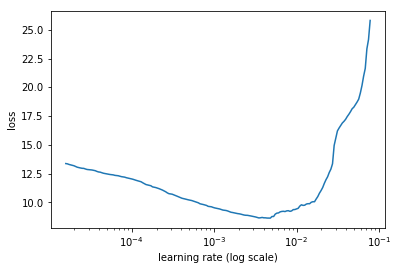

In [134]:
learn.lr_find()
learn.sched.plot()

In [135]:
lr=3e-3

In [137]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10))

 14%|█▎        | 41/302 [00:07<00:46,  5.59it/s, loss=8.9] 
epoch      trn_loss   val_loss                              
    0      5.662628   5.714037  
    1      5.012479   4.973389                              
    2      4.135276   4.450971                              
    3      3.761769   4.068193                              
    4      3.568051   3.95978                               
    5      3.505596   3.749948                              
    6      3.297563   3.684398                              
    7      3.458026   3.567881                              
    8      3.043173   3.55637                               
    9      2.975676   3.514382                              
    10     3.168161   3.467236                              
    11     2.897166   3.482096                              



[array([3.4821])]

In [ ]:
learn.save('initial')

In [ ]:
learn.load('initial')

### Test

In [ ]:
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

for i in range(10,20):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

## Bidir

In [ ]:
class Seq2SeqRNN_Bidir(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        self.drop_enc = nn.Dropout(0.05)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.out_enc(self.drop_enc(h))

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))

In [ ]:
rnn = Seq2SeqRNN_Bidir(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [ ]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10))

In [ ]:
learn.save('bidir')

## Teacher forcing

In [ ]:
class Seq2SeqStepper(Stepper):
    def step(self, xs, y, epoch):
        self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        xtra = []
        output = self.m(*xs, y)
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.data[0]

In [ ]:
class Seq2SeqRNN_TeacherForcing(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 1.
        
    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [ ]:
rnn = Seq2SeqRNN_TeacherForcing(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [ ]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10), stepper=Seq2SeqStepper)

In [ ]:
learn.save('forcing')

## Attentional model

In [ ]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

In [ ]:
class Seq2SeqAttnRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec*2, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        self.W1 = rand_p(nh, em_sz_dec)
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
        self.l3 = nn.Linear(em_sz_dec+nh, em_sz_dec)
        self.V = rand_p(em_sz_dec)

    def forward(self, inp, y=None, ret_attn=False):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            w2h = self.l2(h[-1])
            u = F.tanh(w1e + w2h)
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            emb = self.emb_dec(dec_inp)
            wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]

        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [ ]:
rnn = Seq2SeqAttnRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [ ]:
lr=2e-3

In [ ]:
learn.fit(lr, 1, cycle_len=15, use_clr=(20,10), stepper=Seq2SeqStepper)

In [ ]:
learn.save('attn')

In [ ]:
learn.load('attn')

### Test

In [ ]:
x,y = next(iter(val_dl))
probs,attns = learn.model(V(x),ret_attn=True)
preds = to_np(probs.max(2)[1])

In [ ]:
for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

In [ ]:
attn = to_np(attns[...,180])

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ax.plot(attn[i])

## All

In [ ]:
class Seq2SeqRNN_All(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        self.drop_enc = nn.Dropout(0.25)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        self.W1 = rand_p(nh*2, em_sz_dec)
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
        self.l3 = nn.Linear(em_sz_dec+nh*2, em_sz_dec)
        self.V = rand_p(em_sz_dec)

    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.out_enc(self.drop_enc(h))

        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            w2h = self.l2(h[-1])
            u = F.tanh(w1e + w2h)
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            emb = self.emb_dec(dec_inp)
            wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
        return torch.stack(res)

    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))

In [ ]:
rnn = Seq2SeqRNN_All(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [ ]:
learn.fit(lr, 1, cycle_len=15, use_clr=(20,10), stepper=Seq2SeqStepper)

### Test

In [ ]:
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()